# Import libraries 

In [1]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Other
from IPython.display import clear_output
import h5py

# Set seed

In [2]:
key = jax.random.PRNGKey(42)

W0000 00:00:1764261012.713951 3514492 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1764261012.761995 3514492 service.cc:145] XLA service 0x7fec5e474540 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764261012.762017 3514492 service.cc:153]   StreamExecutor device (0): Metal, <undefined>


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 3.99 GB



I0000 00:00:1764261013.690170 3514492 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1764261013.690187 3514492 mps_client.cc:384] XLA backend will use up to 8572612608 bytes on device 0 for SimpleAllocator.


# Set device type

In [3]:
cpu = jax.devices("cpu")[0]
gpu = jax.devices("METAL")[0]
jax.default_device(gpu)
print(jax.default_backend())

METAL


# Import training data

In [4]:
# Path to your new HDF5 file
file_path = "../data/SIM/simulations_10000_200.h5"

# Open file
simulations = []
with h5py.File(file_path, "r") as f:
    for sim_key in f.keys():  # e.g., sim_0, sim_1, ...
        grp = f[sim_key]
        # Retrieve parameters automatically
        params = {k: grp.attrs[k] for k in grp.attrs.keys()}
        # Retrieve only the columns of interest
        data_grp = grp["data"]
        columns_of_interest = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 
                               'prompt', 'localcolor', 'localcolor_err', 'z']
        data = {col: data_grp[col][:].tolist() for col in columns_of_interest if col in data_grp}
        simulations.append({"params": params, "data": data})

# Example: number of simulations and size
N = len(simulations)
M = len(simulations[0]['data']['magobs'])
print(f"The file contains {N} simulations of size {M}")

The file contains 10000 simulations of size 200


In [5]:
# --- Parameters: dict of arrays (N,) ---
params = {name: jnp.array([sim['params'][name] for sim in simulations])
          for name in simulations[0]['params'].keys()}

# --- Data columns: dict of arrays (N, M) ---
data = {col: jnp.stack([jnp.array(sim['data'][col]) for sim in simulations], axis=0)
        for col in simulations[0]['data'].keys()}

magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

# Apply mask column-wise
data_filt = {
    name: jnp.where(mask, data[name], jnp.nan)   # keep alignment
    for name in data.keys()
}

data_padded = {
    name: jnp.where(mask, data[name], 0)   # keep alignment
    for name in data.keys()
}

# Example usage
print(params['alpha'].shape)   # (N,)
print(data['magobs'].shape)    # (N, M)

(10000,)
(10000, 200)


# Compute residuals

In [7]:
mu_planck18, data_filt['magobs'], params['mabs'] = nntr.rm_cosmo(data_filt['z'], data_filt['magobs'], params['mabs'])

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


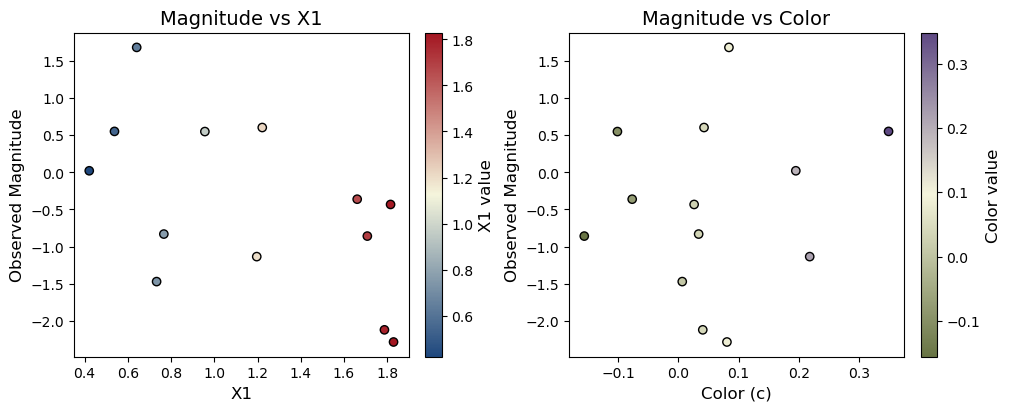

In [8]:
index = 2  # index for your data slice

# Define the color maps
cmap1 = LinearSegmentedColormap.from_list(
    'custom_red_beige_blue',
    ['#1F487E', 'beige', '#A31621']
)

cmap2 = LinearSegmentedColormap.from_list(
    'custom_green_beige_purple',
    ['#687444', 'beige', '#5E4983']
)

# Create figure and horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# First subplot: x1 vs magobs
sc1 = axes[0].scatter(data_filt['x1'][index, :], data_filt['magobs'][index, :], c=data_filt['x1'][index, :], cmap=cmap1, edgecolor='k')
axes[0].set_title('Magnitude vs X1', fontsize=14)
axes[0].set_xlabel('X1', fontsize=12)
axes[0].set_ylabel('Observed Magnitude', fontsize=12)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('X1 value', fontsize=12)

# Second subplot: c vs magobs
sc2 = axes[1].scatter(data_filt['c'][index, :], data_filt['magobs'][index, :], c=data_filt['c'][index, :], cmap=cmap2, edgecolor='k')
axes[1].set_title('Magnitude vs Color', fontsize=14)
axes[1].set_xlabel('Color (c)', fontsize=12)
axes[1].set_ylabel('Observed Magnitude', fontsize=12)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Color value', fontsize=12)

plt.show()


# Prepare train and test sets

## Set bounds

In [9]:
bounds = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

## Label data

In [10]:
K = len(params)  # number of parameters

key, lhs_key = jax.random.split(key)
lhs_samples = nntr.lhs_jax(lhs_key, K, N)   # shape (N, K)

# Convert bounds to arrays
param_names = list(params.keys())
mins = jnp.array([bounds[name]['min'] for name in param_names])
maxs = jnp.array([bounds[name]['max'] for name in param_names])

false_params = mins + (maxs - mins) * lhs_samples  # shape (N,K)

# Masking: produce N×K array of masked parameters
key, label_key = jax.random.split(key)
label_mask = jax.random.uniform(label_key, (N,)) > 0.5  # (N,)

param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)
param_masked = jnp.where(label_mask[:, None], param_true, false_params)  # (N,K)

## Concatenate data

In [ ]:
data_names = list(data_padded.keys())
data_arrays = jnp.array([data_padded[name] for name in data_names])  # each (N,M)

print(jnp.shape(data_arrays))

# Stack into (N, M, C)
data_stacked = jnp.stack(data_arrays, axis=0)

print(jnp.shape(data_stacked))

# Concatenate channels along the last axis → (N, C*M)
data_concat = jnp.concatenate(data_arrays, axis=-1)

print(jnp.shape(data_concat))

inputs = jnp.concatenate([data_concat, param_masked], axis=1)
print(jnp.shape(inputs))
input_with_mask = jnp.concatenate([inputs, mask], axis=1)
print(jnp.shape(input_with_mask))
outputs = label_mask.astype(jnp.int32)[:, None]
print(jnp.shape(outputs))


print("Splitting into train/test...")
key, split_key = jax.random.split(key)
train_data, test_data, train_labels, test_labels = nntr.train_test_split_jax(
    input_with_mask, outputs, test_size=0.3, shuffle=True, key=split_key
)
print('...done')

print("Moving data to device...")
train_data = jax.device_put(train_data)
train_labels = jax.device_put(train_labels)
test_data = jax.device_put(test_data)
test_labels = jax.device_put(test_labels)
print('...done')

(10, 10000, 200)
(10, 10000, 200)
(10000, 2000)
(10000, 2004)
(10000, 2204)
(10000, 1)
Splitting into train/test...
...done
Moving data to device...
...done


# Build a neural network

In [15]:
# Define the size of the different network layers
Nsize_p = 100 #128
Nsize_r =  1200 #2048
phi_batch = 1

n_cols = len(data_names)
print(n_cols)
n_params = len(param_names)
print(n_params)

model_config = {
    'Nsize_p': Nsize_p,
    'Nsize_r': Nsize_r,
    'phi_batch': phi_batch
}

model = nntr.DeepSetClassifier(0.05, Nsize_p, Nsize_r, n_cols, n_params, rngs=nnx.Rngs(0))

# Visualize the model structure
nnx.display(model)

10
4


In [16]:
# Initialise metrics history
metrics_history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

In [17]:
# Define the learning rate schedule
learning_rate_schedule = optax.exponential_decay(
    init_value=5e-4,
    transition_steps=1000,  # Decay every 1000 forward passes
    decay_rate=0.9,
)

momentum = 0.9 # Necessary for the Adam optimiser

# Initialize optimiser with the adaptive learning rate
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate_schedule, momentum))

# Train NN

In [18]:
print(train_data.device)
print(train_labels.device)

METAL:0
METAL:0


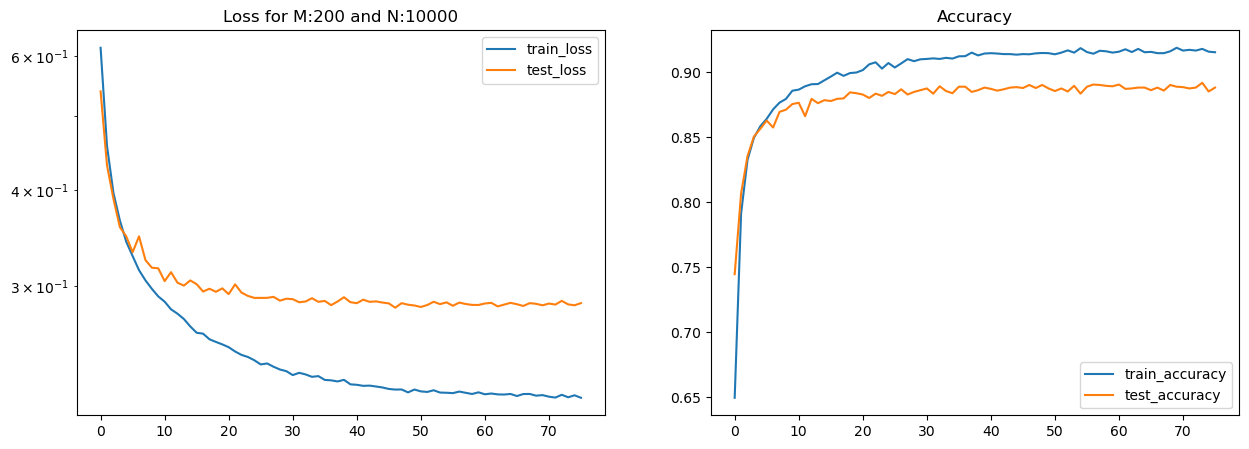


 Early stopping at epoch 77 due to 30 consecutive increases in loss gap 



In [19]:
# Early stopping parameters
patience = 30 # Number of epochs to wait for improvement
epochs = 1000 # Maximum number of epochs

batch_size = 10

# Initialise stopping criteria
best_train_loss = jnp.inf
best_test_loss = jnp.inf
strikes = 0

model.train()
for epoch in range(epochs):
    # Shuffle the training data using JAX.
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, len(train_data))
    train_data = train_data[perm]
    train_labels = train_labels[perm]
    del perm
    
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    
    for i in range(0, len(train_data), batch_size):
        # Get the current batch of data and labels
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        
        # Perform a training step
        loss, _ = nntr.loss_fn(model, (batch_data, batch_labels))
        accuracy = nntr.accuracy_fn(model, (batch_data, batch_labels))
        epoch_train_loss += loss
        epoch_train_accuracy += accuracy
        nntr.train_step(model, optimizer, (batch_data, batch_labels))
    
    # Log the training metrics.
    current_train_loss = epoch_train_loss / (len(train_data) / batch_size)
    metrics_history['train_loss'].append(current_train_loss)
    metrics_history['train_accuracy'].append(epoch_train_accuracy/(len(train_data) / batch_size))

    epoch_test_loss = 0
    epoch_test_accuracy = 0

    # Compute the metrics on the test set using the same batching as training
    for i in range(0, len(test_data), batch_size):
        batch_data = test_data[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]

        loss, _ = nntr.loss_fn(model, (batch_data, batch_labels))
        accuracy = nntr.accuracy_fn(model, (batch_data, batch_labels))
        epoch_test_loss += loss
        epoch_test_accuracy += accuracy

    # Log the test metrics.
    current_test_loss = epoch_test_loss / (len(test_data) / batch_size)
    metrics_history['test_loss'].append(current_test_loss)
    metrics_history['test_accuracy'].append(epoch_test_accuracy/ (len(test_data) / batch_size))
    
    # Early Stopping Check
    if current_test_loss < best_test_loss:
        best_test_loss = current_test_loss  # Update best test loss
        strikes = 0
    elif current_train_loss >= best_train_loss:
        strikes = 0
    elif current_test_loss > best_test_loss and current_train_loss < best_train_loss:
        strikes +=1
    elif current_train_loss < best_train_loss:
        best_train_loss = current_train_loss # Update best train loss

    if strikes >= patience:
        print(f"\n Early stopping at epoch {epoch+1} due to {patience} consecutive increases in loss gap \n")
        break

    if epoch%1 == 0:
        #Plot loss and accuracy in subplots
        clear_output(wait=True) # Clear the output to avoid cluttering
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title(f'Loss for M:{M} and N:{N}')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax1.legend()
            ax1.set_yscale("log")
    
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
            ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
            ax2.legend()
        plt.show()

# Test NN

## Test Accuracy

In [20]:
model.eval()  # disable dropout, etc.

batch_size = 128  # tune this to fit your RAM; lower → safer

# Accumulators
all_logits = []
all_labels = []

# Loop over your test set in-place
num_samples = test_data.shape[0]
for i in range(0, num_samples, batch_size):
    xb = test_data[i : i + batch_size]
    yb = test_labels[i : i + batch_size]

    # Get logits for this mini-batch
    logits = nntr.pred_step(model, xb)
    all_logits.append(logits)

    # Store the corresponding true labels
    all_labels.append(yb > 0.5)

# Merge everything back together
all_logits = jnp.concatenate(all_logits, axis=0)
all_preds  = jsp.special.expit(all_logits) > 0.5
all_labels = jnp.concatenate(all_labels, axis=0)

# === same metrics computation as before ===
TP = jnp.sum((all_preds == 1) & (all_labels == 1))
TN = jnp.sum((all_preds == 0) & (all_labels == 0))
FP = jnp.sum((all_preds == 1) & (all_labels == 0))
FN = jnp.sum((all_preds == 0) & (all_labels == 1))

print(f"True positives : {TP}")
print(f"True negatives : {TN}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}\n")

accuracy    = (TP + TN) / (TP + TN + FP + FN)
precision   = TP / (TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy   : {accuracy:.3f}")
print(f"Precision  : {precision:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

True positives : 1423
True negatives : 1249
False positives: 259
False negatives: 69

Accuracy   : 0.891
Precision  : 0.846
Sensitivity: 0.954
Specificity: 0.828


## Test TARP

In [21]:
# ========== Run TARP test ==========
model.eval()

BOUNDS = jnp.array([[bounds['alpha']['min'],bounds['alpha']['max']], [bounds['beta']['min'], bounds['beta']['max']]]) # Change to use directly dictionnary
NDIM = BOUNDS.shape[0]

# Select samples with true parameters in the test set
indices = jnp.where(test_labels)[0]
xy_test = test_data[indices, :3*M+2]
theta_test = test_data[indices, -NDIM:]

size = int(jnp.minimum(500, indices.shape[0]))
xy_test = xy_test[:size, :]
theta_test = theta_test[:size, :]

alpha_grid = jnp.linspace(0, 1, 50)

print("Launching MCMC (JIT‐compiled)...")
# Run the MCMC sampling on CPU for speed
# with jax.default_device(cpu):
ecp, post, key = nnte.compute_ecp_tarp_jitted(
    model, xy_test, theta_test, alpha_grid,
    n_warmup=200, n_samples=500, rng_key=key
)
print("MCMC finished")

Launching MCMC (JIT‐compiled)...


TypeError: one_sample_step() missing 5 required positional arguments: 'model', 'a_min', 'a_max', 'b_min', and 'b_max'

In [ ]:
# ========== Plotting ECP vs (1 - alpha) ==========
plt.figure(figsize=(8, 6))
plt.plot(1 - alpha_grid, ecp, 'o-', label='Expected Coverage Probability (ECP)')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
plt.xlabel(r'$1 - \alpha$')
plt.ylabel("ECP")
plt.title("ECP vs $1 - \\alpha$ on Test Set (Filtered)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save NN to disk

In [ ]:
# Save the trained model for future use
nntr.save_nn(model,'../data/NNs/nn_model', model_config)